# Extended and Enhanced MVTec AD Anomaly Detection Script for **Capsule**
This notebook trains a **patch-based** autoencoder on `capsule/train/good` images (MVTec AD Capsule) and evaluates on defect images (`capsule/test/`).

1. **Train** patch-based autoencoder.
2. **Infer** on test images (crack, faulty_imprint, etc.).
3. **Compare** predictions to ground-truth masks (pixel-level) and compute IoU & AUC.
4. **Save** model to `Models_dump/model_capsule_patch.pth`.
5. **Generate** CSV: `Output/anomaly_capsule.csv`.
6. **(Optional)** Produce heatmaps in `Output/Heatmaps/capsule/`.

> **Make sure** the following folders exist:
> - `Input/capsule/train/good`
> - `Input/capsule/test/[defect_type]`
> - `Input/capsule/ground_truth/[defect_type]`
> - `Models_dump/`
> - `Output/`

Let's get started!

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1. Dataset Classes

### 1.1 `CapsuleTrainDataset`
*Loads images from `Input/capsule/train/good` and randomly samples patches.*

### 1.2 `CapsuleTestDataset`
*Loads full test images from each subfolder (`crack`, `poke`, etc.), used for sliding-window evaluation.*

In [6]:
class CapsuleTrainDataset(Dataset):
    def __init__(self, root_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Input/capsule/train/good", 
                 transform=None, 
                 patch_size=128, 
                 patches_per_image=5):
        """
        root_dir: folder of good training images (e.g. Input/capsule/train/good)
        transform: torchvision transforms
        patch_size: size of the square patch (e.g. 128)
        patches_per_image: how many random patches to extract from each image per epoch
        """
        self.image_paths = []
        for fname in os.listdir(root_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(root_dir, fname))
        self.image_paths.sort()
        self.transform = transform
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image

    def __len__(self):
        # We will treat each image as having `patches_per_image` samples.
        return len(self.image_paths) * self.patches_per_image

    def __getitem__(self, idx):
        # Map idx back to an image.
        img_idx = idx // self.patches_per_image
        img_path = self.image_paths[img_idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        # image: Tensor [3, H, W]
        C, H, W = image.shape
        # Random top-left corner
        if H < self.patch_size or W < self.patch_size:
            # If the image is smaller than patch_size, pad it or just resize.
            # For simplicity, let's do a center-crop if it's smaller.
            # But typically you'd want to ensure images >= patch_size.
            patch = image
        else:
            i = np.random.randint(0, H - self.patch_size + 1)
            j = np.random.randint(0, W - self.patch_size + 1)
            patch = image[:, i:i+self.patch_size, j:j+self.patch_size]

        return patch


class CapsuleTestDataset(Dataset):
    def __init__(self, root_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Input/capsule/test", transform=None):
        """
        root_dir: e.g. Input/capsule/test
          with subfolders: crack, faulty_imprint, poke, scratch, squeeze
        transform: torchvision transforms
        """
        self.image_paths = []
        self.defect_types = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        for defect in self.defect_types:
            defect_dir = os.path.join(root_dir, defect)
            for fname in os.listdir(defect_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(defect_dir, fname))
        self.image_paths.sort()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

## 2. Patch-Based Autoencoder
We’ll train on **patches** only. Then, for inference, we’ll **sliding-window** across the test image to get a full error map.

In [7]:
class CapsulePatchAutoencoder(nn.Module):
    def __init__(self):
        super(CapsulePatchAutoencoder, self).__init__()
        # Feel free to tweak the kernel sizes, channels, etc.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 3. Training the Patch Autoencoder

Epoch [1/10], Loss: 0.0272
Epoch [2/10], Loss: 0.0028
Epoch [3/10], Loss: 0.0016
Epoch [4/10], Loss: 0.0010
Epoch [5/10], Loss: 0.0009
Epoch [6/10], Loss: 0.0006
Epoch [7/10], Loss: 0.0005
Epoch [8/10], Loss: 0.0005
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004


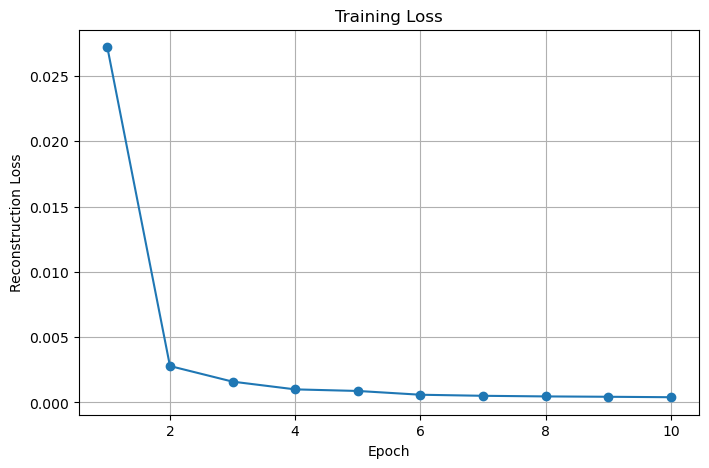

In [8]:
# Hyperparams
PATCH_SIZE = 128
PATCHES_PER_IMAGE = 5
BATCH_SIZE = 16
EPOCHS = 10  # Increase if you want better results
LR = 1e-3

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # ensure consistent size
    transforms.ToTensor()
])

# Prepare dataset & dataloader
train_dataset = CapsuleTrainDataset(
    root_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Input/capsule/train/good", 
    transform=train_transform,
    patch_size=PATCH_SIZE,
    patches_per_image=PATCHES_PER_IMAGE
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create model
model = CapsulePatchAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for patches in train_loader:
        patches = patches.to(device)
        optimizer.zero_grad()
        recon = model(patches)
        loss = criterion(recon, patches)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * patches.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

# Plot training curve
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.grid(True)
plt.show()


## 4. Evaluation on Test Images
We’ll **slide** a window of size `PATCH_SIZE` over each test image to compute a **reconstruction error map**. Then:

- Compare to `ground_truth` masks for pixel-level metrics (IoU, ROC-AUC).
- Save results into a DataFrame -> **`Output/anomaly_capsule.csv`**.
- (Optional) Save **heatmaps** into `Output/Heatmaps/capsule/...`.

### 4.1 Helper Functions

In [9]:
def get_mask_path(img_path):
    """
    Convert something like:
      Input/capsule/test/crack/001.png
    into
      Input/capsule/ground_truth/crack/001_mask.png
    You may need to adjust the exact suffix.
    """
    # We'll assume it's something like: X.png -> X_mask.png
    # Also replace "/test/" with "/ground_truth/".
    mask_path = img_path.replace("/test/", "/ground_truth/")
    mask_path = mask_path.replace(".png", "_mask.png")
    return mask_path

def compute_pixel_error_map(original, recon):
    """
    original, recon: Tensors of shape [1, C, H, W] or [C, H, W].
    We'll return the mean of absolute difference across channels => shape [H, W].
    """
    if original.dim() == 4:
        # [B=1, C, H, W]
        diff = torch.abs(original - recon)
        diff = diff.mean(dim=1).squeeze(0)  # => [H, W]
    else:
        # [C, H, W]
        diff = torch.abs(original - recon)
        diff = diff.mean(dim=0)  # => [H, W]
    return diff.detach().cpu().numpy()

def compute_iou(error_map, mask_path, threshold=0.5):
    if not os.path.exists(mask_path):
        return None
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((error_map.shape[1], error_map.shape[0]), Image.NEAREST)
    gt = (np.array(mask) > 128).astype(np.uint8)
    pred = (error_map > threshold).astype(np.uint8)
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    if union == 0:
        return 1.0 if intersection == 0 else 0
    return float(intersection) / float(union)

def compute_roc_auc(error_map, mask_path):
    if not os.path.exists(mask_path):
        return None
    mask = Image.open(mask_path).convert("L")
    mask = mask.resize((error_map.shape[1], error_map.shape[0]), Image.NEAREST)
    y_true = (np.array(mask).flatten() > 128).astype(np.uint8)
    y_score = error_map.flatten()
    if y_true.sum() == 0:
        # no positive pixels -> skip or return None
        return None
    return roc_auc_score(y_true, y_score)

def generate_heatmap(error_map, original_tensor):
    """
    Create a heatmap from error_map [H, W], then overlay on original.
    """
    emap = error_map.copy()
    emap -= emap.min()
    emap /= (emap.max() + 1e-8)
    emap = (emap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(emap, cv2.COLORMAP_JET)

    orig = (original_tensor * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    overlay = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)
    return overlay

def save_visualization(overlay, out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # Convert RGB->BGR for cv2.imwrite
    overlay_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
    cv2.imwrite(out_path, overlay_bgr)

### 4.2 Inference via Sliding Window

In [10]:
def sliding_window_inference(image_tensor, model, patch_size=128, stride=64):
    """
    image_tensor: [C, H, W]
    We'll produce a final error_map: [H, W]
    by summing patch errors, then dividing by counts.
    """
    model.eval()
    C, H, W = image_tensor.shape
    error_map = np.zeros((H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)

    with torch.no_grad():
        for i in range(0, H - patch_size + 1, stride):
            for j in range(0, W - patch_size + 1, stride):
                patch = image_tensor[:, i:i+patch_size, j:j+patch_size].unsqueeze(0).to(device)
                recon = model(patch)
                diff_map = compute_pixel_error_map(patch, recon)  # shape [patch_size, patch_size]
                error_map[i:i+patch_size, j:j+patch_size] += diff_map
                count_map[i:i+patch_size, j:j+patch_size] += 1

    # average
    count_map[count_map == 0] = 1  # avoid div by zero
    final_map = error_map / count_map
    return final_map

def evaluate_capsule_test(model, patch_size=128, stride=64, threshold=0.5, 
                          csv_path="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Output/anomaly_capsule.csv", 
                          heatmap_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Output/Heatmaps/capsule"):
    """
    1. Load all test images from CapsuleTestDataset.
    2. Perform sliding-window inference.
    3. Compare with ground-truth mask -> iou, auc.
    4. Save to CSV, optionally save heatmaps.
    """
    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    test_dataset = CapsuleTestDataset(root_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Input/capsule/test", transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    results = []
    model.eval()
    for img_tensor, img_path in test_loader:
        # img_tensor shape: [1, 3, H, W]
        img_tensor = img_tensor.squeeze(0)  # => [3, H, W]

        # get patch-based reconstruction error map
        error_map = sliding_window_inference(
            img_tensor, model, patch_size=patch_size, stride=stride
        )

        # compute IoU, AUC
        mask_p = get_mask_path(img_path[0])
        iou_val = compute_iou(error_map, mask_p, threshold)
        auc_val = compute_roc_auc(error_map, mask_p)

        # For summary, let's store average error (0-1 range) * 100 => percent
        mean_error = np.mean(error_map)
        error_percent = mean_error * 100

        # Generate heatmap for visualization
        overlay = generate_heatmap(error_map, img_tensor)
        # Decide output path
        rel_path = os.path.relpath(img_path[0], start="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Input/capsule/test")
        out_path = os.path.join(heatmap_dir, rel_path)
        save_visualization(overlay, out_path)

        results.append({
            "file": rel_path,
            "error_percent": error_percent,
            "iou": iou_val,
            "auc": auc_val
        })

    df = pd.DataFrame(results)
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df.to_csv(csv_path, index=False)
    return df


### 4.3 Run the Evaluation & Save the Model

In [11]:
# Save the trained model
MODEL_PATH = "/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Models_dump/model_capsule_patch.pth"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Evaluate on test set
CSV_PATH = "/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Output/anomaly_capsule.csv"
df_results = evaluate_capsule_test(
    model,
    patch_size=PATCH_SIZE,
    stride=64,
    threshold=0.5,
    csv_path=CSV_PATH,
    heatmap_dir="/Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Output/Heatmaps/capsule"
)
print(df_results.head())
print(f"Saved anomaly results to {CSV_PATH}")

Model saved to /Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Models_dump/model_capsule_patch.pth
            file  error_percent  iou       auc
0  crack/000.png       1.049297  0.0  0.825804
1  crack/001.png       1.222760  0.0  0.954652
2  crack/002.png       1.185301  0.0  0.850465
3  crack/003.png       1.055900  0.0  0.873003
4  crack/004.png       1.206841  0.0  0.992997
Saved anomaly results to /Users/asr/Desktop/College/Sem 1 MTech/CV/project/CV-Anomaly-Detection-in-Manufacturing-/Output/anomaly_capsule.csv


## 5. Quick Analysis of Results

Basic stats:
       error_percent    iou         auc
count     132.000000  109.0  109.000000
mean        1.127795    0.0    0.812459
std         0.097959    0.0    0.134436
min         0.997923    0.0    0.418556
25%         1.074480    0.0    0.743377
50%         1.114215    0.0    0.850465
75%         1.150803    0.0    0.912013
max         1.683688    0.0    0.992997


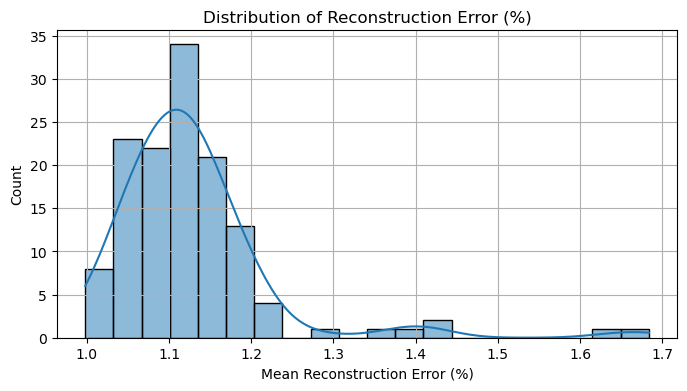

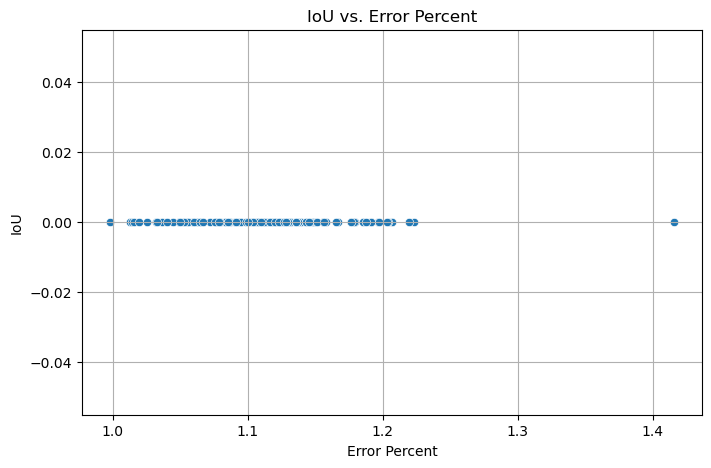

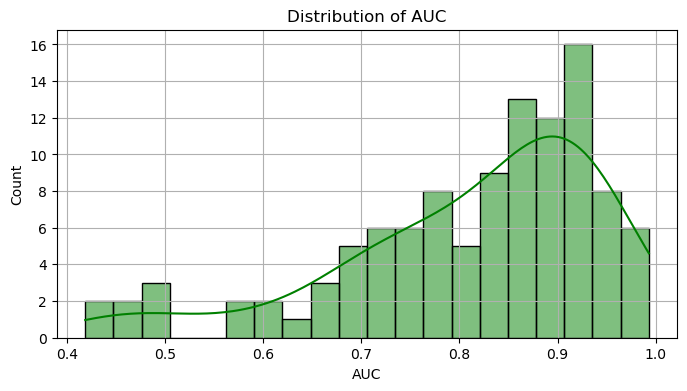

In [12]:
import seaborn as sns

print("Basic stats:")
print(df_results.describe())

# Distribution of Reconstruction Error
plt.figure(figsize=(8, 4))
sns.histplot(df_results["error_percent"], bins=20, kde=True)
plt.title("Distribution of Reconstruction Error (%)")
plt.xlabel("Mean Reconstruction Error (%)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# IoU vs. Error Percent
plt.figure(figsize=(8, 5))
sns.scatterplot(x="error_percent", y="iou", data=df_results)
plt.title("IoU vs. Error Percent")
plt.xlabel("Error Percent")
plt.ylabel("IoU")
plt.grid(True)
plt.show()

# AUC distribution (if we have any non-null values)
if "auc" in df_results.columns and df_results["auc"].notna().any():
    plt.figure(figsize=(8, 4))
    sns.histplot(df_results["auc"].dropna(), bins=20, kde=True, color="green")
    plt.title("Distribution of AUC")
    plt.xlabel("AUC")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()